In [87]:
"""
Created 16/11/2022

@author: Mithrandir - Şaban Kara
"""

import numpy as np
import numpy.ma as ma
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import tabulate

In [88]:
import sys
print("User Current Version:-", sys.version)

"""
python 3.7 olmalı
"""

User Current Version:- 3.7.15 (default, Nov  9 2022, 10:44:37) [MSC v.1916 64 bit (AMD64)]


'\npython 3.7 olmalı\n'

In [89]:
top10_df = pd.read_csv("./data/content_top10_df.csv")
bygenre_df = pd.read_csv("./data/content_bygenre_df.csv")
top10_df

,movie id,num ratings,ave rating,title,genres
0,4993,198,4.106061,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
1,5952,188,4.021277,"Lord of the Rings: The Two Towers, The",Adventure|Fantasy
2,7153,185,4.118919,"Lord of the Rings: The Return of the King, The",Action|Adventure|Drama|Fantasy
3,4306,170,3.867647,Shrek,Adventure|Animation|Children|Comedy|Fantasy|Ro...
4,58559,149,4.238255,"Dark Knight, The",Action|Crime|Drama
5,6539,149,3.778523,Pirates of the Caribbean: The Curse of the Bla...,Action|Adventure|Comedy|Fantasy
6,79132,143,4.066434,Inception,Action|Crime|Drama|Mystery|Sci-Fi|Thriller
7,6377,141,3.960993,Finding Nemo,Adventure|Animation|Children|Comedy
8,4886,132,3.871212,"Monsters, Inc.",Adventure|Animation|Children|Comedy|Fantasy
9,7361,131,4.160305,Eternal Sunshine of the Spotless Mind,Drama|Romance|Sci-Fi


* İndirgenmiş veri kümesinde 𝑛𝑢=397 kullanıcı, 𝑛𝑚=847 film ve 25521 derecelendirme vardır.
* Veri kümesi, her film için bir film başlığı, çıkış tarihi ve bir veya daha fazla tür sağlar. Örneğin, "Oyuncak Hikayesi 3" 2010'da yayınlandı ve birkaç türü var: "Macera|Animasyon|Çocuklar|Komedi|Fantezi".

In [90]:
bygenre_df

,genre,num movies,ave rating/genre,ratings per genre
0,Action,321,3.37,10377
1,Adventure,234,3.42,8785
2,Animation,76,3.63,2588
3,Children,69,3.44,2472
4,Comedy,326,3.36,8911
5,Crime,139,3.54,4671
6,Documentary,13,3.81,280
7,Drama,342,3.61,10201
8,Fantasy,124,3.37,4468
9,Horror,56,3.20,1345


#### Content-based filtering with a neural network
* İşbirlikçi filtreleme bir kullanıcı vektörü ve nokta çarpımı bir derecelendirmeyi tahmin eden bir öğe/film vektörü. Vektörler yalnızca derecelendirmelerden türetilmişti. 

* İçerik tabanlı filtreleme aynı zamanda bir kullanıcı ve film özellik vektörü oluşturur, ancak kullanıcı ve/veya film hakkında tahmini iyileştirebilecek başka bilgiler olabileceğini kabul eder. Daha sonra aşağıda gösterildiği gibi kullanıcıyı ve film vektörünü oluşturan bir sinir ağına sağlanır.

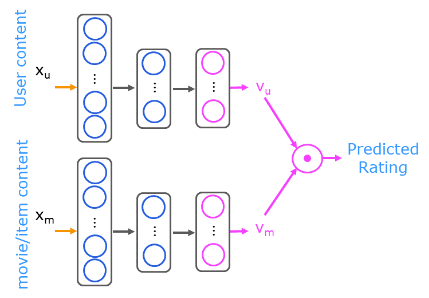

#### Training Data
* Kullanıcı içeriği, tasarlanmış özelliklerden oluşur. Tür başına bir ortalama derecelendirme, kullanıcı başına hesaplanır. Ek olarak, bir kullanıcı kimliği, derecelendirme sayısı ve derecelendirme ortalaması mevcuttur ancak eğitim veya tahmin içeriğine dahil değildir. Verilerin yorumlanmasında faydalı oldukları için veri seti ile birlikte taşınırlar.

* Eğitim seti, veri setinde kullanıcılar tarafından yapılan tüm derecelendirmelerden oluşmaktadır. Yeterince temsil edilmeyen türlerin eğitim örneklerinin sayısını artırmak için bazı derecelendirmeler tekrarlanır. Eğitim seti, aynı sayıda girişe sahip iki diziye, bir kullanıcı dizisine ve bir film/öğe dizisine bölünmüştür.

* Bazı veriler;

In [91]:
# Load Data, set configuration variables
item_train, user_train, y_train, item_features, user_features, item_vecs, movie_dict, user_to_genre = load_data()

num_user_features = user_train.shape[1] - 3  # remove userid, rating count and ave rating during training
num_item_features = item_train.shape[1] - 1  # remove movie id at train time
uvs = 3  # user genre vector start
ivs = 3  # item genre vector start
u_s = 3  # start of columns to use in training, user
i_s = 1  # start of columns to use in training, items
print(f"Number of training vectors: {len(item_train)}")

Number of training vectors: 50884


In [92]:
pprint_train(user_train, user_features, uvs,  u_s, maxcount=5)

[user id],[rating count],[rating ave],Act ion,Adve nture,Anim ation,Chil dren,Com edy,Crime,Docum entary,Drama,Fan tasy,Hor ror,Mys tery,Rom ance,Sci -Fi,Thri ller
2,22,4.0,4.0,4.2,0.0,0.0,4.0,4.1,4.0,4.0,0.0,3.0,4.0,0.0,3.9,3.9
2,22,4.0,4.0,4.2,0.0,0.0,4.0,4.1,4.0,4.0,0.0,3.0,4.0,0.0,3.9,3.9
2,22,4.0,4.0,4.2,0.0,0.0,4.0,4.1,4.0,4.0,0.0,3.0,4.0,0.0,3.9,3.9
2,22,4.0,4.0,4.2,0.0,0.0,4.0,4.1,4.0,4.0,0.0,3.0,4.0,0.0,3.9,3.9
2,22,4.0,4.0,4.2,0.0,0.0,4.0,4.1,4.0,4.0,0.0,3.0,4.0,0.0,3.9,3.9


* Bazı kullanıcı ve öğe/film özellikleri eğitimde kullanılmaz. Yukarıdaki tabloda, "user id", "reyting sayısı" ve "reyting ave" gibi parantez "[]" içindeki özellikler, model eğitilip kullanıldığında dahil edilmez. Yukarıda, kullanıcı 2 için tür başına derecelendirme ortalamasını görebilirsiniz. Sıfır girişler, kullanıcının derecelendirmediği türlerdir. Kullanıcı vektörü, bir kullanıcı tarafından derecelendirilen tüm filmler için aynıdır.

In [93]:
pprint_train(item_train, item_features, ivs, i_s, maxcount=5, user=False)

[movie id],year,ave rating,Act ion,Adve nture,Anim ation,Chil dren,Com edy,Crime,Docum entary,Drama,Fan tasy,Hor ror,Mys tery,Rom ance,Sci -Fi,Thri ller
6874,2003,4.0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
8798,2004,3.8,1,0,0,0,0,1,0,1,0,0,0,0,0,1
46970,2006,3.2,1,0,0,0,1,0,0,0,0,0,0,0,0,0
48516,2006,4.3,0,0,0,0,0,1,0,1,0,0,0,0,0,1
58559,2008,4.2,1,0,0,0,0,1,0,1,0,0,0,0,0,0


* Yukarıdaki film dizisi, filmin gösterime girdiği yılı, ortalama reytingi ve her potansiyel tür için bir göstergeyi içerir. Gösterge, film için geçerli olan her tür için birdir. Film kimliği eğitimde kullanılmaz, ancak verileri yorumlarken kullanışlıdır.

In [94]:
print(f"y_train[:5]: {y_train[:5]}")

y_train[:5]: [4.  3.5 4.  4.  4.5]


* target y, kullanıcı tarafından verilen film derecelendirmesidir.

* Yukarıda 6874 filminin 2003 yılında vizyona girmiş bir Aksiyon/Suç/Gerilim filmi olduğunu görebiliriz. Kullanıcı 2 aksiyon filmlerini ortalama 3.9 olarak derecelendirmiştir. MovieLens kullanıcıları filme ortalama 4 puan verdi. 'y' 4, kullanıcı 2'nin filmi 6874 olarak da 4 olarak derecelendirdiğini gösterir. Tek bir eğitim örneği, hem kullanıcı hem de öğe dizilerinden bir satır ve y_train'den bir derecelendirmeden oluşur.

#### Preparing the training data
* Yakınsamayı iyileştirmenin bir yolu olarak özellik ölçeklendirmedir.
* Scikit Learn StandardScaler'ı kullanarak giriş özelliklerini ölçeklendireceğiz.
* Aşağıda, inverse_transform'un da orijinal girdileri ürettiği gösterilmiştir. Hedef derecelendirmelerini, hedefi -1 ile 1 arasında olacak şekilde ölçekleyen bir Min Maks Ölçekleyici kullanarak ölçeklendirildi.

In [95]:
# scale training data
item_train_unscaled = item_train
user_train_unscaled = user_train
y_train_unscaled    = y_train

scalerItem = StandardScaler()
scalerItem.fit(item_train)
item_train = scalerItem.transform(item_train)

scalerUser = StandardScaler()
scalerUser.fit(user_train)
user_train = scalerUser.transform(user_train)

scalerTarget = MinMaxScaler((-1, 1))
scalerTarget.fit(y_train.reshape(-1, 1))
y_train = scalerTarget.transform(y_train.reshape(-1, 1))
#ynorm_test = scalerTarget.transform(y_test.reshape(-1, 1))

print(np.allclose(item_train_unscaled, scalerItem.inverse_transform(item_train)))
print(np.allclose(user_train_unscaled, scalerUser.inverse_transform(user_train)))

True
True


* Sonuçları değerlendirmemize izin vermek için, Kurs 2, 3. Hafta'da tartışıldığı gibi verileri eğitim ve test kümelerine ayıracağız. Burada verileri bölmek ve karıştırmak için sklean train_test_split kullanacağız. İlk rasgele durumun aynı değere ayarlanması öğe, kullanıcı ve y'nin aynı şekilde karıştırılmasını sağlar.

In [96]:
item_train, item_test = train_test_split(item_train, train_size=0.80, shuffle=True, random_state=1)
user_train, user_test = train_test_split(user_train, train_size=0.80, shuffle=True, random_state=1)
y_train, y_test       = train_test_split(y_train,    train_size=0.80, shuffle=True, random_state=1)
print(f"movie/item training data shape: {item_train.shape}")
print(f"movie/item test data shape: {item_test.shape}")

movie/item training data shape: (40707, 17)
movie/item test data shape: (10177, 17)


* Ölçeklenmiş, karıştırılmış verilerin artık bir ortalaması sıfırdır.

In [97]:
pprint_train(user_train, user_features, uvs, u_s, maxcount=5)

[user id],[rating count],[rating ave],Act ion,Adve nture,Anim ation,Chil dren,Com edy,Crime,Docum entary,Drama,Fan tasy,Hor ror,Mys tery,Rom ance,Sci -Fi,Thri ller
1,0,-1.0,-0.8,-0.7,0.1,-0.0,-1.2,-0.4,0.6,-0.5,-0.5,-0.1,-0.6,-0.6,-0.7,-0.7
0,1,-0.7,-0.5,-0.7,-0.1,-0.2,-0.6,-0.2,0.7,-0.5,-0.8,0.1,-0.0,-0.6,-0.5,-0.4
-1,-1,-0.2,0.3,-0.4,0.4,0.5,1.0,0.6,-1.2,-0.3,-0.6,-2.3,-0.1,0.0,0.4,-0.0
0,-1,0.6,0.5,0.5,0.2,0.6,-0.1,0.5,-1.2,0.9,1.2,-2.3,-0.1,0.0,0.2,0.3
-1,0,0.7,0.6,0.5,0.3,0.5,0.4,0.6,1.0,0.6,0.3,0.8,0.8,0.4,0.7,0.7


#### Neural Network for content-based filtering
* İki ağ oluşturuldu.  Kullanıcı içeriği, film içeriğinden önemli ölçüde daha büyükse, kullanıcı ağının karmaşıklığını film ağına göre artırmayı seçebilebilir. 

In [98]:
num_outputs = 32
tf.random.set_seed(1)
user_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs, activation='linear'),  
])

item_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs, activation='linear'),
])

# create the user input and point to the base network
input_user = tf.keras.layers.Input(shape=(num_user_features))
vu = user_NN(input_user)
vu = tf.linalg.l2_normalize(vu, axis=1)

# create the item input and point to the base network
input_item = tf.keras.layers.Input(shape=(num_item_features))
vm = item_NN(input_item)
vm = tf.linalg.l2_normalize(vm, axis=1)

# compute the dot product of the two vectors vu and vm
output = tf.keras.layers.Dot(axes=1)([vu, vm])

# specify the inputs and output of the model
model = tf.keras.Model([input_user, input_item], output)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 14)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 sequential_4 (Sequential)      (None, 32)           40864       ['input_5[0][0]']                
                                                                                                  
 sequential_5 (Sequential)      (None, 32)           41376       ['input_6[0][0]']                
                                                                                            

* Ortalama bir kare hata kaybı ve bir AdamOptimizers kullanıldı.

In [99]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt,
              loss=cost_fn)
tf.random.set_seed(1)
hist = model.fit([user_train[:, u_s:], item_train[:, i_s:]], y_train, epochs=30)

Epoch 1/30
1273/1273 [==============================] - 4s 3ms/step - loss: 0.1229
Epoch 2/30
1273/1273 [==============================] - 3s 2ms/step - loss: 0.1142
Epoch 3/30
1273/1273 [==============================] - 3s 3ms/step - loss: 0.1108
Epoch 4/30
1273/1273 [==============================] - 3s 3ms/step - loss: 0.1066
Epoch 5/30
1273/1273 [==============================] - 3s 3ms/step - loss: 0.1034
Epoch 6/30
1273/1273 [==============================] - 3s 3ms/step - loss: 0.1002
Epoch 7/30
1273/1273 [==============================] - 3s 3ms/step - loss: 0.0977
Epoch 8/30
1273/1273 [==============================] - 3s 3ms/step - loss: 0.0957
Epoch 9/30
1273/1273 [==============================] - 3s 3ms/step - loss: 0.0938
Epoch 10/30
1273/1273 [==============================] - 3s 3ms/step - loss: 0.0923
Epoch 11/30
1273/1273 [==============================] - 4s 3ms/step - loss: 0.0907
Epoch 12/30
1273/1273 [==============================] - 3s 3ms/step - loss: 0.0890
E

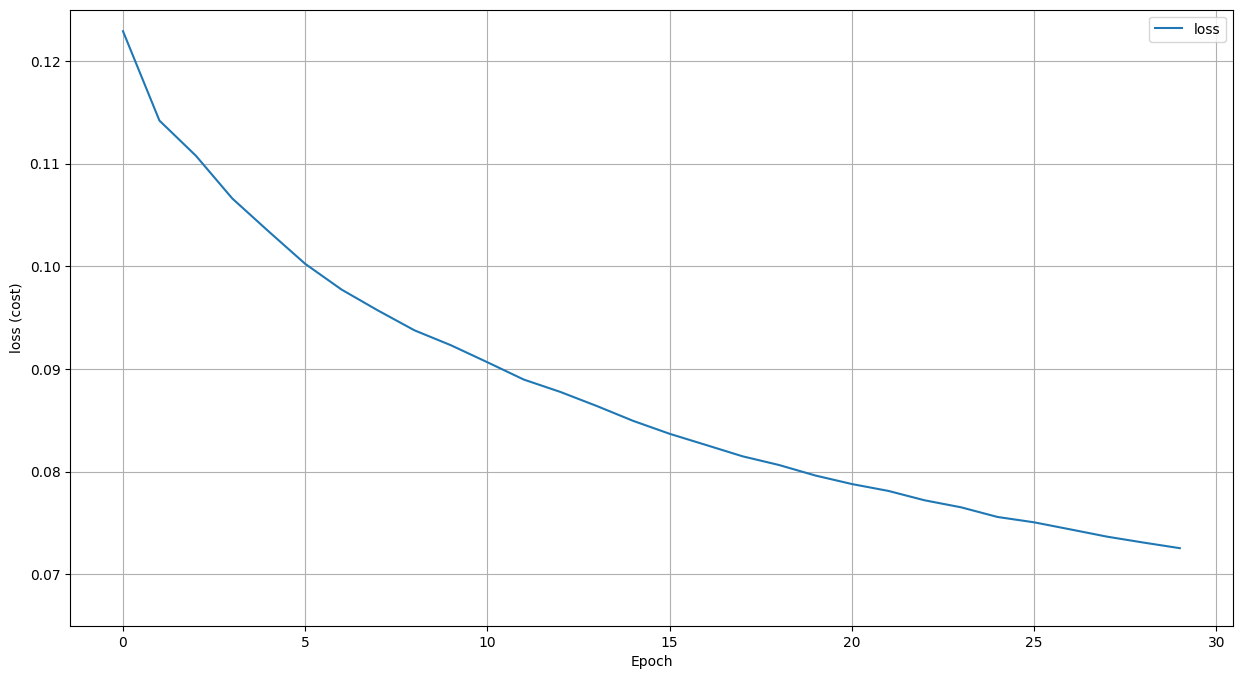

In [100]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1, figsize = (15,8))

ax.plot(hist.history['loss'], label='loss')

ax.set_ylim([0.065, 0.125])
ax.set_xlabel('Epoch')
ax.set_ylabel('loss (cost)')
ax.legend()
ax.grid(True)

plt.show()

In [101]:
model.evaluate([user_test[:, u_s:], item_test[:, i_s:]], y_test)

319/319 [==============================] - 1s 2ms/step - loss: 0.0824


0.08237669616937637

#### Predictions for a new user
* Öncelikle yeni bir kullanıcı oluşturulacak ve modelin o kullanıcıya film önermesini sağlanacak. Bunu örnek kullanıcı içeriği üzerinde denedikten sonra, kullanıcı içeriğini kendi tercihlerinize uyacak şekilde değiştirilebilir.

In [102]:
new_user_id = 5000
new_rating_ave = 0.0
new_action = 0.0
new_adventure = 5.0
new_animation = 0.0
new_childrens = 0.0
new_comedy = 0.0
new_crime = 0.0
new_documentary = 0.0
new_drama = 0.0
new_fantasy = 5.0
new_horror = 0.0
new_mystery = 0.0
new_romance = 0.0
new_scifi = 0.0
new_thriller = 0.0
new_rating_count = 3

user_vec = np.array([[new_user_id, new_rating_count, new_rating_ave,
                      new_action, new_adventure, new_animation, new_childrens,
                      new_comedy, new_crime, new_documentary,
                      new_drama, new_fantasy, new_horror, new_mystery,
                      new_romance, new_scifi, new_thriller]])

* Yeni kullanıcı, macera, fantezi türlerinden filmlerden hoşlanır. Yeni kullanıcı için en çok oy alan filmleri bulalım.
* Aşağıda, eğitim/test setindeki her film için bir vektörü olan bir dizi film/öğe vektörü, item_vecs kullanacağız. Bu, yukarıdaki yeni kullanıcı vektörüyle eşleştirilir ve ölçeklenen vektörler, tüm filmlerin derecelendirmelerini tahmin etmek için kullanılır.

In [103]:
# generate and replicate the user vector to match the number movies in the data set.
user_vecs = gen_user_vecs(user_vec,len(item_vecs))

# scale our user and item vectors
suser_vecs = scalerUser.transform(user_vecs)
sitem_vecs = scalerItem.transform(item_vecs)

# make a prediction
y_p = model.predict([suser_vecs[:, u_s:], sitem_vecs[:, i_s:]])

# unscale y prediction 
y_pu = scalerTarget.inverse_transform(y_p)

# sort the results, highest prediction first
sorted_index = np.argsort(-y_pu,axis=0).reshape(-1).tolist()  #negate to get largest rating first
sorted_ypu   = y_pu[sorted_index]
sorted_items = item_vecs[sorted_index]  #using unscaled vectors for display

print_pred_movies(sorted_ypu, sorted_items, movie_dict, maxcount = 10)

27/27 [==============================] - 0s 2ms/step


y_p,movie id,rating ave,title,genres
4.3,8368,3.9,Harry Potter and the Prisoner of Azkaban (2004),Adventure|Fantasy
4.3,5952,4,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
4.2,40815,3.8,Harry Potter and the Goblet of Fire (2005),Adventure|Fantasy|Thriller
4.2,59387,4,"Fall, The (2006)",Adventure|Drama|Fantasy
4.2,98809,3.8,"Hobbit: An Unexpected Journey, The (2012)",Adventure|Fantasy
4.2,54001,3.9,Harry Potter and the Order of the Phoenix (2007),Adventure|Drama|Fantasy
4.2,4993,4.1,"Lord of the Rings: The Fellowship of the Ring, The (2001)",Adventure|Fantasy
4.2,81834,4,Harry Potter and the Deathly Hallows: Part 1 (2010),Action|Adventure|Fantasy
4.2,5816,3.6,Harry Potter and the Chamber of Secrets (2002),Adventure|Fantasy
4.1,7153,4.1,"Lord of the Rings: The Return of the King, The (2003)",Action|Adventure|Drama|Fantasy


####  Predictions for an existing user.
* Veri setindeki kullanıcılardan biri olan "user 2" için tahminlere bakalım. Öngörülen derecelendirmeleri modelin derecelendirmeleriyle karşılaştırabiliriz

In [104]:
uid = 2 
# form a set of user vectors. This is the same vector, transformed and repeated.
user_vecs, y_vecs = get_user_vecs(uid, user_train_unscaled, item_vecs, user_to_genre)

# scale our user and item vectors
suser_vecs = scalerUser.transform(user_vecs)
sitem_vecs = scalerItem.transform(item_vecs)

# make a prediction
y_p = model.predict([suser_vecs[:, u_s:], sitem_vecs[:, i_s:]])

# unscale y prediction 
y_pu = scalerTarget.inverse_transform(y_p)

# sort the results, highest prediction first
sorted_index = np.argsort(-y_pu,axis=0).reshape(-1).tolist()  #negate to get largest rating first
sorted_ypu   = y_pu[sorted_index]
sorted_items = item_vecs[sorted_index]  #using unscaled vectors for display
sorted_user  = user_vecs[sorted_index]
sorted_y     = y_vecs[sorted_index]

#print sorted predictions for movies rated by the user
print_existing_user(sorted_ypu, sorted_y.reshape(-1,1), sorted_user, sorted_items, ivs, uvs, movie_dict, maxcount = 50)

27/27 [==============================] - 0s 2ms/step


y_p,y,user,user genre ave,movie rating ave,movie id,title,genres
4.4,5.0,2,[4.0],4.3,80906,Inside Job (2010),Documentary
4.3,4.0,2,"[4.0,4.1,3.9]",4.0,6874,Kill Bill: Vol. 1 (2003),Action|Crime|Thriller
4.3,3.5,2,"[4.0,4.1,4.0,3.9]",3.8,8798,Collateral (2004),Action|Crime|Drama|Thriller
4.2,3.5,2,"[4.0,4.0]",3.9,99114,Django Unchained (2012),Action|Drama
4.0,4.5,2,"[4.0,4.0]",4.1,68157,Inglourious Basterds (2009),Action|Drama
4.0,4.5,2,"[4.0,4.1,4.0]",4.2,58559,"Dark Knight, The (2008)",Action|Crime|Drama
4.0,4.0,2,"[4.0,4.1,4.0,4.0,3.9,3.9]",4.1,79132,Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller
4.0,4.0,2,"[4.1,4.0,3.9]",4.3,48516,"Departed, The (2006)",Crime|Drama|Thriller
4.0,4.5,2,"[4.1,4.0,3.9]",4.0,80489,"Town, The (2010)",Crime|Drama|Thriller
4.0,5.0,2,[4.0],3.6,60756,Step Brothers (2008),Comedy


* Model tahmini genellikle gerçek derecelendirmenin 1'i dahilindedir, ancak bir kullanıcının belirli filmleri nasıl derecelendirdiği konusunda çok doğru bir tahmin edici değildir. Bu, özellikle kullanıcı derecelendirmesi, kullanıcının tür ortalamasından önemli ölçüde farklıysa geçerlidir. Farklı kullanıcıları denemek için yukarıdaki kullanıcı kimliğini değiştirebilirsiniz. Eğitim setinde tüm kullanıcı kimlikleri kullanılmadı.

#### Predictions for a new user


In [111]:
# Şaban Kara zevkleri için
new_user_id = 5001
new_rating_ave = 0.0
new_action = 0.0
new_adventure = 5.0
new_animation = 0.0
new_childrens = 0.0
new_comedy = 0.0
new_crime = 0.0
new_documentary = 0.0
new_drama = 0.0
new_fantasy = 5.0
new_horror = 0.0
new_mystery = 0.0
new_romance = 0.0
new_scifi = 0.0
new_thriller = 0.0
new_rating_count = 3

user_vec = np.array([[new_user_id, new_rating_count, new_rating_ave,
                      new_action, new_adventure, new_animation, new_childrens,
                      new_comedy, new_crime, new_documentary,
                      new_drama, new_fantasy, new_horror, new_mystery,
                      new_romance, new_scifi, new_thriller]])


# generate and replicate the user vector to match the number movies in the data set.
user_vecs = gen_user_vecs(user_vec,len(item_vecs))

# scale our user and item vectors
suser_vecs = scalerUser.transform(user_vecs)
sitem_vecs = scalerItem.transform(item_vecs)

# make a prediction
y_p = model.predict([suser_vecs[:, u_s:], sitem_vecs[:, i_s:]])

# unscale y prediction 
y_pu = scalerTarget.inverse_transform(y_p)

# sort the results, highest prediction first
sorted_index = np.argsort(-y_pu,axis=0).reshape(-1).tolist()  #negate to get largest rating first
sorted_ypu   = y_pu[sorted_index]
sorted_items = item_vecs[sorted_index]  #using unscaled vectors for display

print_pred_movies(sorted_ypu, sorted_items, movie_dict, maxcount = 10)



27/27 [==============================] - 0s 2ms/step


y_p,movie id,rating ave,title,genres
4.3,8368,3.9,Harry Potter and the Prisoner of Azkaban (2004),Adventure|Fantasy
4.3,5952,4,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
4.2,40815,3.8,Harry Potter and the Goblet of Fire (2005),Adventure|Fantasy|Thriller
4.2,59387,4,"Fall, The (2006)",Adventure|Drama|Fantasy
4.2,98809,3.8,"Hobbit: An Unexpected Journey, The (2012)",Adventure|Fantasy
4.2,54001,3.9,Harry Potter and the Order of the Phoenix (2007),Adventure|Drama|Fantasy
4.2,4993,4.1,"Lord of the Rings: The Fellowship of the Ring, The (2001)",Adventure|Fantasy
4.2,81834,4,Harry Potter and the Deathly Hallows: Part 1 (2010),Action|Adventure|Fantasy
4.2,5816,3.6,Harry Potter and the Chamber of Secrets (2002),Adventure|Fantasy
4.1,7153,4.1,"Lord of the Rings: The Return of the King, The (2003)",Action|Adventure|Drama|Fantasy


#### Finding Similar Items
* Yukarıdaki sinir ağı iki özellik vektörü, bir kullanıcı özellik vektörü 𝑣𝑢 ve bir film özellik vektörü 𝑣𝑚 üretir. Bunlar, değerlerinin yorumlanması zor olan 32 giriş vektörüdür. Ancak, benzer öğelerin benzer vektörleri olacaktır. Bu bilgiler tavsiyelerde bulunmak için kullanılabilir. Örneğin, bir kullanıcı "Oyuncak Hikayesi 3"ü yüksek oranda derecelendirdiyse, benzer film özellik vektörlerine sahip filmler seçerek benzer filmler önerilebilir.

* Benzerlik ölçüsü, iki vektör arasındaki mesafenin karesidir $ \mathbf{v_m^{(k)}}$ and $\mathbf{v_m^{(i)}}$ :

$$\left\Vert \mathbf{v_m^{(k)}} - \mathbf{v_m^{(i)}}  \right\Vert^2 = \sum_{l=1}^{n}(v_{m_l}^{(k)} - v_{m_l}^{(i)})^2\tag{1}$$

In [113]:
def sq_dist(a,b):
    """
    Returns the squared distance between two vectors
    Args:
      a (ndarray (n,)): vector with n features
      b (ndarray (n,)): vector with n features
    Returns:
      d (float) : distance
    """

    d = sum(np.square(a-b))

    return d

a1 = np.array([1.0, 2.0, 3.0]); b1 = np.array([1.0, 2.0, 3.0])
a2 = np.array([1.1, 2.1, 3.1]); b2 = np.array([1.0, 2.0, 3.0])
a3 = np.array([0, 1, 0]);       b3 = np.array([1, 0, 0])
print(f"squared distance between a1 and b1: {sq_dist(a1, b1):0.3f}")
print(f"squared distance between a2 and b2: {sq_dist(a2, b2):0.3f}")
print(f"squared distance between a3 and b3: {sq_dist(a3, b3):0.3f}")

squared distance between a1 and b1: 0.000
squared distance between a2 and b2: 0.030
squared distance between a3 and b3: 2.000


* Filmler arasındaki mesafe matrisi, model eğitildiğinde bir kez hesaplanabilir ve daha sonra yeniden eğitmeden yeni öneriler için yeniden kullanılabilir. Bir model eğitildikten sonra ilk adım, filmlerin her biri için film özellik vektörünü 𝑣𝑚 elde etmektir. Bunu yapmak için, eğitilmiş item_NN'yi kullanacağız ve 𝑣𝑚 oluşturmak için film vektörlerini içinden geçirmemize izin verecek küçük bir model oluşturacağız.

In [114]:
input_item_m = tf.keras.layers.Input(shape=(num_item_features))    # input layer
vm_m = item_NN(input_item_m)                                       # use the trained item_NN
vm_m = tf.linalg.l2_normalize(vm_m, axis=1)                        # incorporate normalization as was done in the original model
model_m = tf.keras.Model(input_item_m, vm_m)                                
model_m.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 16)]              0         
                                                                 
 sequential_5 (Sequential)   (None, 32)                41376     
                                                                 
 tf.math.l2_normalize_6 (TFO  (None, 32)               0         
 pLambda)                                                        
                                                                 
Total params: 41,376
Trainable params: 41,376
Non-trainable params: 0
_________________________________________________________________


* Bir film modeliniz olduğunda, girdi olarak bir dizi öğe/film vektörü kullanarak tahminde bulunmak için modeli kullanarak bir dizi film özelliği vektörü oluşturabilirsiniz. item_vecs, tüm film vektörlerinin bir kümesidir. Eğitilmiş modelle kullanmak için ölçeklendirilmelidir. Tahminin sonucu, her film için 32 girişli bir özellik vektörüdür.

In [115]:
scaled_item_vecs = scalerItem.transform(item_vecs)
vms = model_m.predict(scaled_item_vecs[:,i_s:])
print(f"size of all predicted movie feature vectors: {vms.shape}")

27/27 [==============================] - 0s 1ms/step
size of all predicted movie feature vectors: (847, 32)


* Şimdi her film özellik vektörü ile diğer tüm film özellik vektörleri arasındaki mesafenin karesini alan bir matris hesaplayalım:

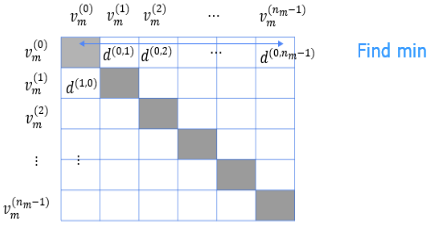

Daha sonra her satır boyunca minimum olanı bularak en yakın filmi bulabiliriz. Aynı filmi seçmemek için numpy maskeli dizileri kullanacağız. Köşegen boyunca maskelenmiş değerler hesaplamaya dahil edilmeyecektir.

In [116]:
count = 50  # number of movies to display
dim = len(vms)
dist = np.zeros((dim,dim))

for i in range(dim):
    for j in range(dim):
        dist[i,j] = sq_dist(vms[i, :], vms[j, :])
        
m_dist = ma.masked_array(dist, mask=np.identity(dist.shape[0]))  # mask the diagonal

disp = [["movie1", "genres", "movie2", "genres"]]
for i in range(count):
    min_idx = np.argmin(m_dist[i])
    movie1_id = int(item_vecs[i,0])
    movie2_id = int(item_vecs[min_idx,0])
    disp.append( [movie_dict[movie1_id]['title'], movie_dict[movie1_id]['genres'],
                  movie_dict[movie2_id]['title'], movie_dict[movie1_id]['genres']]
               )
table = tabulate.tabulate(disp, tablefmt='html', headers="firstrow")
table

movie1,genres,movie2,genres
Save the Last Dance (2001),Drama|Romance,Mona Lisa Smile (2003),Drama|Romance
"Wedding Planner, The (2001)",Comedy|Romance,"Sweetest Thing, The (2002)",Comedy|Romance
Hannibal (2001),Horror|Thriller,Final Destination 2 (2003),Horror|Thriller
Saving Silverman (Evil Woman) (2001),Comedy|Romance,Maid in Manhattan (2002),Comedy|Romance
Down to Earth (2001),Comedy|Fantasy|Romance,America's Sweethearts (2001),Comedy|Fantasy|Romance
"Mexican, The (2001)",Action|Comedy,Rush Hour 2 (2001),Action|Comedy
15 Minutes (2001),Thriller,Panic Room (2002),Thriller
Enemy at the Gates (2001),Drama,"Aviator, The (2004)",Drama
Heartbreakers (2001),Comedy|Crime|Romance,Fun with Dick and Jane (2005),Comedy|Crime|Romance
Spy Kids (2001),Action|Adventure|Children|Comedy,Scooby-Doo (2002),Action|Adventure|Children|Comedy


In [105]:
from collections import defaultdict
import csv
import numpy as np
from numpy import genfromtxt
import pickle5 as pickle
import tabulate


def load_data():
    ''' called to load preprepared data for the lab '''
    item_train = genfromtxt('./data/content_item_train.csv', delimiter=',')
    user_train = genfromtxt('./data/content_user_train.csv', delimiter=',')
    y_train    = genfromtxt('./data/content_y_train.csv', delimiter=',')
    with open('./data/content_item_train_header.txt', newline='') as f:    #csv reader handles quoted strings better
        item_features = list(csv.reader(f))[0]
    with open('./data/content_user_train_header.txt', newline='') as f:
        user_features = list(csv.reader(f))[0]
    item_vecs = genfromtxt('./data/content_item_vecs.csv', delimiter=',')

    movie_dict = defaultdict(dict)
    count = 0
#    with open('./data/movies.csv', newline='') as csvfile:
    with open('./data/content_movie_list.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='"')
        for line in reader:
            if count == 0:
                count += 1  #skip header
                #print(line) print
            else:
                count += 1
                movie_id = int(line[0])
                movie_dict[movie_id]["title"] = line[1]
                movie_dict[movie_id]["genres"] = line[2]

    with open('./data/content_user_to_genre.pickle', 'rb') as f:
        user_to_genre = pickle.load(f)

    return(item_train, user_train, y_train, item_features, user_features, item_vecs, movie_dict, user_to_genre)

def pprint_train(x_train, features, vs, u_s, maxcount=5, user=True):
    """ Prints user_train or item_train nicely """
    if user:
        flist = [".0f", ".0f", ".1f",
                 ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f"]
    else:
        flist = [".0f", ".0f", ".1f", 
                 ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f"]

    head = features[:vs]
    if vs < u_s: print("error, vector start {vs} should be greater then user start {u_s}")
    for i in range(u_s):
        head[i] = "[" + head[i] + "]"
    genres = features[vs:]
    hdr = head + genres
    disp = [split_str(hdr, 5)]
    count = 0
    for i in range(0, x_train.shape[0]):
        if count == maxcount: break
        count += 1
        disp.append([x_train[i, 0].astype(int),
                     x_train[i, 1].astype(int),
                     x_train[i, 2].astype(float),
                     *x_train[i, 3:].astype(float)
                    ])
    table = tabulate.tabulate(disp, tablefmt='html', headers="firstrow", floatfmt=flist, numalign='center')
    return table


def split_str(ifeatures, smax):
    ''' split the feature name strings to tables fit '''
    ofeatures = []
    for s in ifeatures:
        if not ' ' in s:  # skip string that already have a space
            if len(s) > smax:
                mid = int(len(s)/2)
                s = s[:mid] + " " + s[mid:]
        ofeatures.append(s)
    return ofeatures
    

def print_pred_movies(y_p, item, movie_dict, maxcount=10):
    """ print results of prediction of a new user. inputs are expected to be in
        sorted order, unscaled. """
    count = 0
    disp = [["y_p", "movie id", "rating ave", "title", "genres"]]

    for i in range(0, y_p.shape[0]):
        if count == maxcount:
            break
        count += 1
        movie_id = item[i, 0].astype(int)
        disp.append([np.around(y_p[i, 0], 1), item[i, 0].astype(int), np.around(item[i, 2].astype(float), 1),
                     movie_dict[movie_id]['title'], movie_dict[movie_id]['genres']])

    table = tabulate.tabulate(disp, tablefmt='html', headers="firstrow")
    return table

def gen_user_vecs(user_vec, num_items):
    """ given a user vector return:
        user predict maxtrix to match the size of item_vecs """
    user_vecs = np.tile(user_vec, (num_items, 1))
    return user_vecs

# predict on  everything, filter on print/use
def predict_uservec(user_vecs, item_vecs, model, u_s, i_s, scaler):
    """ given a scaled user vector, does the prediction on all movies in scaled print_item_vecs returns
        an array predictions sorted by predicted rating,
        arrays of user and item, sorted by predicted rating sorting index
    """
    y_p = model.predict([user_vecs[:, u_s:], item_vecs[:, i_s:]])
    y_pu = scaler.inverse_transform(y_p)

    if np.any(y_pu < 0):
        print("Error, expected all positive predictions")
    sorted_index = np.argsort(-y_pu, axis=0).reshape(-1).tolist()  #negate to get largest rating first
    sorted_ypu   = y_pu[sorted_index]
    sorted_items = item_vecs[sorted_index]
    sorted_user  = user_vecs[sorted_index]
    return(sorted_index, sorted_ypu, sorted_items, sorted_user)
                
def get_user_vecs(user_id, user_train, item_vecs, user_to_genre):
    """ given a user_id, return:
        user train/predict matrix to match the size of item_vecs
        y vector with ratings for all rated movies and 0 for others of size item_vecs """

    if not user_id in user_to_genre:
        print("error: unknown user id")
        return None
    else:
        user_vec_found = False
        for i in range(len(user_train)):
            if user_train[i, 0] == user_id:
                user_vec = user_train[i]
                user_vec_found = True
                break
        if not user_vec_found:
            print("error in get_user_vecs, did not find uid in user_train")
        num_items = len(item_vecs)
        user_vecs = np.tile(user_vec, (num_items, 1))

        y = np.zeros(num_items)
        for i in range(num_items):  # walk through movies in item_vecs and get the movies, see if user has rated them
            movie_id = item_vecs[i, 0]
            if movie_id in user_to_genre[user_id]['movies']:
                rating = user_to_genre[user_id]['movies'][movie_id]
            else:
                rating = 0
            y[i] = rating
    return(user_vecs, y)

def get_item_genres(item_gvec, genre_features):
    ''' takes in the item's genre vector and list of genre names
    returns the feature names where gvec was 1 '''
    offsets = np.nonzero(item_gvec)[0]
    genres = [genre_features[i] for i in offsets]
    return genres


def print_existing_user(y_p, y, user, items, ivs, uvs, movie_dict, maxcount=10):
    """ print results of prediction for a user who was in the database.
        Inputs are expected to be in sorted order, unscaled.
    """
    count = 0
    disp = [["y_p", "y", "user", "user genre ave", "movie rating ave", "movie id", "title", "genres"]]
    count = 0
    for i in range(0, y.shape[0]):
        if y[i, 0] != 0:  # zero means not rated
            if count == maxcount:
                break
            count += 1
            movie_id = items[i, 0].astype(int)

            offsets = np.nonzero(items[i, ivs:] == 1)[0]
            genre_ratings = user[i, uvs + offsets]
            disp.append([y_p[i, 0], y[i, 0],
                         user[i, 0].astype(int),      # userid
                         np.array2string(genre_ratings, 
                                         formatter={'float_kind':lambda x: "%.1f" % x},
                                         separator=',', suppress_small=True),
                         items[i, 2].astype(float),    # movie average rating
                         movie_id,
                         movie_dict[movie_id]['title'],
                         movie_dict[movie_id]['genres']])

    table = tabulate.tabulate(disp, tablefmt='html', headers="firstrow", floatfmt=[".1f", ".1f", ".0f", ".2f", ".1f"])
    return table
